In [1]:
import sys

sys.path.append("..")

from tools.tools import (
    preprocess_data,
    load_sample,
    graph_to_label_tensor,
)
from tools.scoring_tools import score
from tools.display_tools import plot_current_state_of_graph, simple_sample_display
from tools.baseline_methods import var_baseline
import pickle

from hydra import initialize, compose

In [2]:
%load_ext autoreload
%autoreload 2

# Dataset usage tutorial

### Displaying graphs

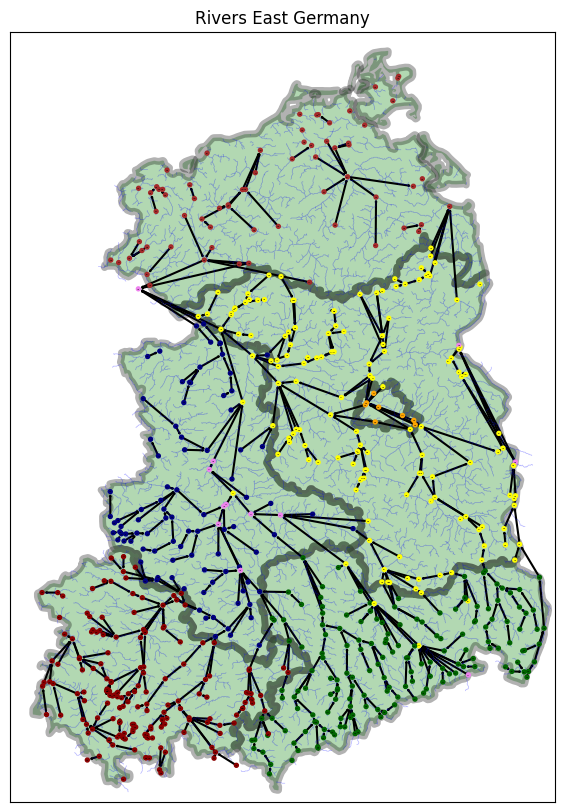

In [3]:
# Visualize the full graph
G = pickle.load(open("product/rivers_east_germany.p", "rb"))
plot_current_state_of_graph(
    G,
    node_size=8,
    save=0,
    river_map=True,
    ger_map=True,
    width=1.5,
    arrowsize=1,
    fs=(10, 10),
    font_size=1,
)

### Scoring a sample

In [4]:
# Lets load a single subgraph set
labels = pickle.load(open("datasets/random_5/east.p", "rb"))
# Choose a random single sample
example = labels[23]
# load the data of the single sample
data = load_sample(p="product/rivers_ts_east_germany.csv" , which= example)

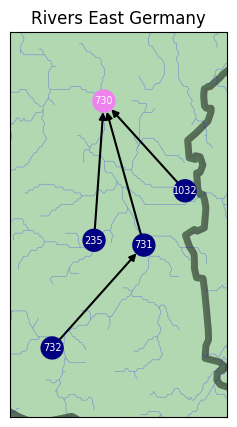

In [5]:
# We can use the same plotting function to visualize the sample
plot_current_state_of_graph(
    example,
    autozoom=0.1,
    node_size=250,
    save=0,
    river_map=True,
    ger_map=True,
    width=1.5,
    arrowsize=10,
    fs=(5, 5),
    font_size=7,
    font_color = "white"
)

In [6]:
# labels can be exported from graph like this:
label = graph_to_label_tensor(example, human_readable=True)
label

Cause                    
             235  730  731  732  1032
Effect 235    0.0  0.0  0.0  0.0  0.0
       730    1.0  0.0  1.0  0.0  1.0
       731    0.0  0.0  0.0  1.0  0.0
       732    0.0  0.0  0.0  0.0  0.0
       1032   0.0  0.0  0.0  0.0  0.0

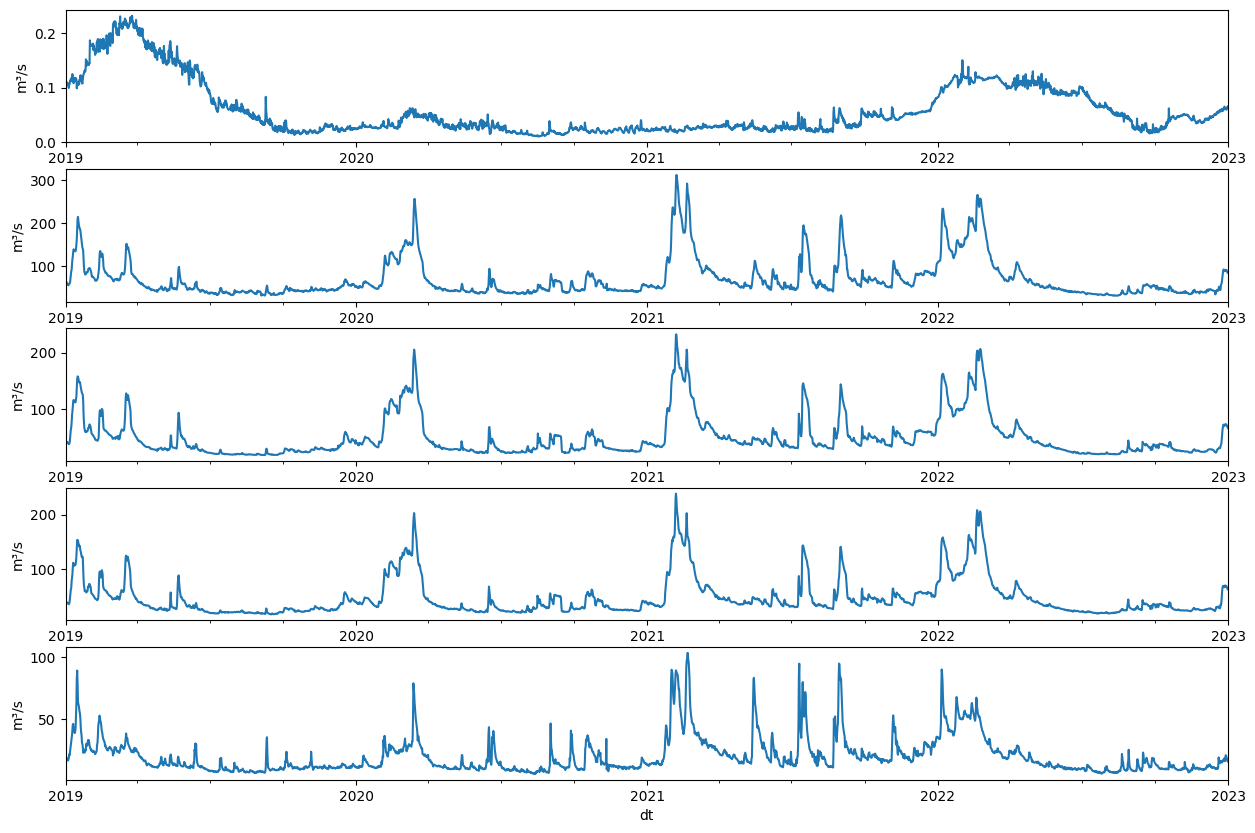

In [7]:
# Run some standard preprocessing steps.
# Importantly we have an option that removes trailing nans (so nans at the end and the beginning of the ts).
# This however removes large parts of the time series if one of the univariate time series has a large portion of nans. 
# To not remove this much information from the other time series, we chose to not do this during our experiments. 
# Feel free to play arround with it however (in this particular examples it would probably be a good idea) :) 

sample_data = preprocess_data(
    data,
    resolution="12h",
    interpolate=True,
    normalize=False,
    remove_trailing_nans_early=True
)
#quick sample display
simple_sample_display(sample_data)

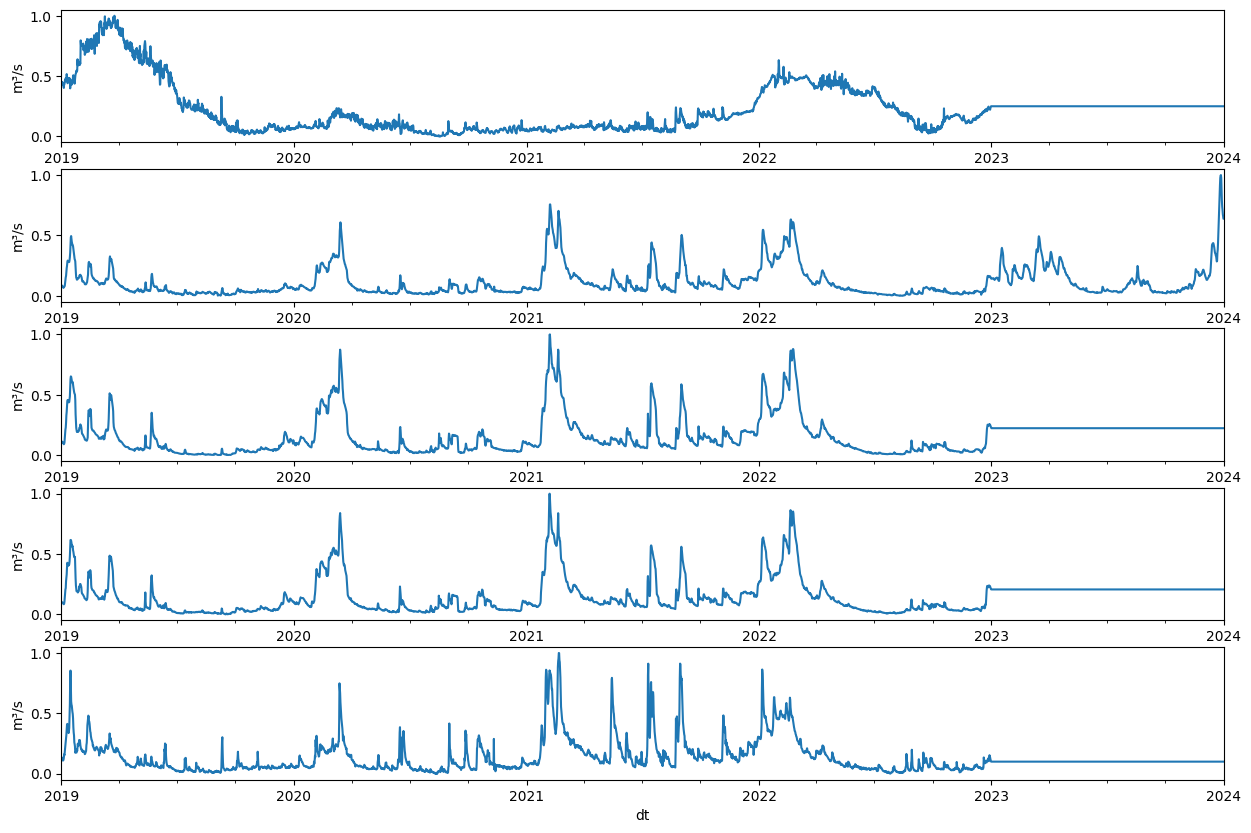

In [8]:
sample_data = preprocess_data(
    data,
    resolution="12h",
    interpolate=True,
    normalize=True,
    remove_trailing_nans_early=False
)
#quick sample display
simple_sample_display(sample_data)

In [9]:
# load default params. They can be changed however you want.
with initialize(version_base=None, config_path="config/method"):
    cfg = compose(config_name='var.yaml')
    print(cfg)
cfg.max_lag = 2

{'name': 'var', 'max_lag': 3, 'var_absolute_values': True, 'map_to_summary_graph': 'max'}


In [10]:
res = var_baseline(sample_data,cfg, human_readable=True)
res 

Cause                                        
                  235       730       731       732      1032
Effect 235   0.513167  0.016758  0.051081  0.050978  0.017354
       730   0.011690  1.430704  0.146693  0.493721  0.101082
       731   0.034193  0.062112  0.506365  1.270193  0.039794
       732   0.065003  0.070338  0.404228  1.785169  0.069812
       1032  0.155092  0.131862  0.181171  0.784497  1.184807

In [11]:
# Use score to get a number of statistics. YOu can throw in a list of examples, pd.Datafames or numpy arrays
score(res,label, name="Example scoring")

Scoring...
0 / 1


,Example scoring
Metric,
Max Acc thresh,0.791962
Max Acc,0.850000
Max individual Acc thresh,0.791962
Max individual Acc,0.850000
Null Acc,0.800000
Max F1 thresh,0.101082
Max F1,0.461538
Max individual F1 thresh,0.101082
Max individual F1,0.461538


### Also check out  ***benchmark.py*** for a streamlined version to process multiple samples!